In [1]:
# import basics
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import progressbar

# import custom
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))
from sscode.config import default_evaluation_metrics
from sscode.data import load_moana_hindcast
from sscode.validation import generate_stats
from sscode.plotting.validation import plot_stats
from sscode.plotting.utils import get_n_colors, plot_ccrs_nz

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


In [2]:
# load results
linear = xr.open_dataset('../data/statistics/experiments/experiment_linear_final_20211012.nc')
knn = xr.open_dataset('../data/statistics/experiments/experiment_knn_final_20211011.nc')
xgboost = xr.open_dataset('../data/statistics/experiments/experiment_xgboost_final_20211013.nc')
mdarbf = xr.open_dataset(
    '../data/statistics/experiments/experiment_mdarbf_shores_1D_local_winds_grad_25_10_1500.nc')

In [3]:
# load all coast results
linear_all_loc = xr.open_dataset('../data/statistics/models/stats_lm_local_daily.nc')
linear_all_reg = xr.open_dataset('../data/statistics/models/stats_lm_regional_daily.nc')
knn_all_loc = xr.open_dataset('../data/statistics/models/stats_knn_local_daily.nc')
knn_all_reg = xr.open_dataset('../data/statistics/models/stats_knn_regional_daily.nc')
xgboost_all_loc = xr.open_dataset('../data/statistics/models/stats_xgboost_local_daily.nc')
xgboost_all_reg = xr.open_dataset('../data/statistics/models/stats_xgboost_regional_daily.nc')

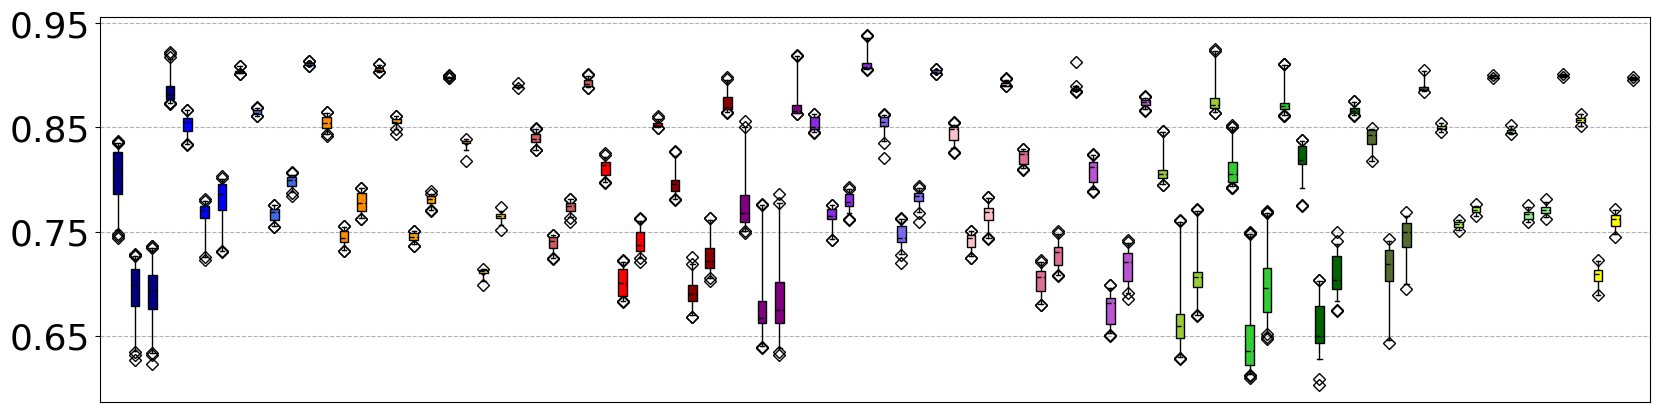

In [4]:
# load the sites in each shore
shore_sites = np.load('../data/statistics/shore_sites_last.npy',allow_pickle=True)
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

# make the boxplots
fig, ax = plt.subplots(figsize=(20,5))
for idata,data in enumerate([linear_all_reg,knn_all_reg,xgboost_all_reg,mdarbf]):
    box = ax.boxplot(
        [data.sel(station=shore_sites[i]).pearson.values for i in range(len(shore_sites))],
        patch_artist=True, sym='D', vert=True, whis=[2,98], widths=0.25, 
        medianprops={'c':'k','lw':1,'ls':'--'}, positions=np.arange(1,45,2)+0.5*idata
    ) if idata!=3 else ax.boxplot(
        [data.sel(shore=i).pearson.max(dim='experiment').values \
         for i in range(len(np.unique(data.shore.values)))],
        patch_artist=True, sym='D', vert=True, whis=[2,98], widths=0.25, 
        medianprops={'c':'k','lw':1,'ls':'--'}, positions=np.arange(1,45,2)+0.5*idata
    )
    loc_colors = [
        'navy','blue','royalblue','darkorange','orange','gold','indianred','red','darkred',
        'purple','blueviolet','mediumslateblue','pink','palevioletred','mediumorchid',
        'yellowgreen','limegreen','darkgreen','darkolivegreen','greenyellow','lightgreen','yellow'
    ]
    for patch, color in zip(box['boxes'], loc_colors):
        patch.set_facecolor(color)
    ax.set_xticks([])
    ax.set_ylabel('',fontsize=22,labelpad=20)
    ax.set_yticks([0.65,0.75,0.85,0.95])
    ax.set_yticklabels([0.65,0.75,0.85,0.95],fontsize=26)
    ax.grid(ls='--')
plt.show()

In [5]:
# order mdarbf dataset and load linear final results
ordered_mdarbf = mdarbf.isel(shore=
    list(np.intersect1d(mdarbf.site.values,linear_all_reg.station.values,return_indices=True)[1]))
ordered_mdarbf = ordered_mdarbf.assign({
    'latitude': (('shore'),linear_all_reg.latitude.values),
    'longitude': (('shore'),linear_all_reg.longitude.values)
})
linear_all = xr.open_dataset(
    '../data/statistics/experiments/experiment_linear_final_all_sites.nc'
).isel(grad=0,perpcs=0,region=0,tlapse=0,tresample=0,tsize=0,winds=0)
linear_all = linear_all.assign({
    'latitude': (('site'),linear_all_reg.latitude.values),
    'longitude': (('site'),linear_all_reg.longitude.values)
})

In [6]:
print(ordered_mdarbf,linear_all)

<xarray.Dataset>
Dimensions:       (experiment: 24, shore: 1448, time: 8109)
Coordinates:
  * experiment    (experiment) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * shore         (shore) int64 5 5 5 5 5 5 5 5 5 ... 17 17 17 17 17 17 17 17 17
  * time          (time) datetime64[ns] 1994-11-13 1994-11-14 ... 2017-02-11
    site          (shore) int64 0 1 2 3 4 5 6 ... 1442 1443 1444 1445 1446 1447
Data variables: (12/17)
    ss_interp     (experiment, shore, time) float64 ...
    perpcs        (experiment, shore) float64 ...
    nsamples      (experiment, shore) float64 ...
    bias          (experiment, shore) float64 ...
    si            (experiment, shore) float64 ...
    rmse          (experiment, shore) float64 ...
    ...            ...
    ext_pearson   (experiment, shore) float64 ...
    pocid         (experiment, shore) float64 ...
    tu_test       (experiment, shore) float64 ...
    expl_var      (experiment, shore) float64 ...
    latitude      (shore) float64 -50.

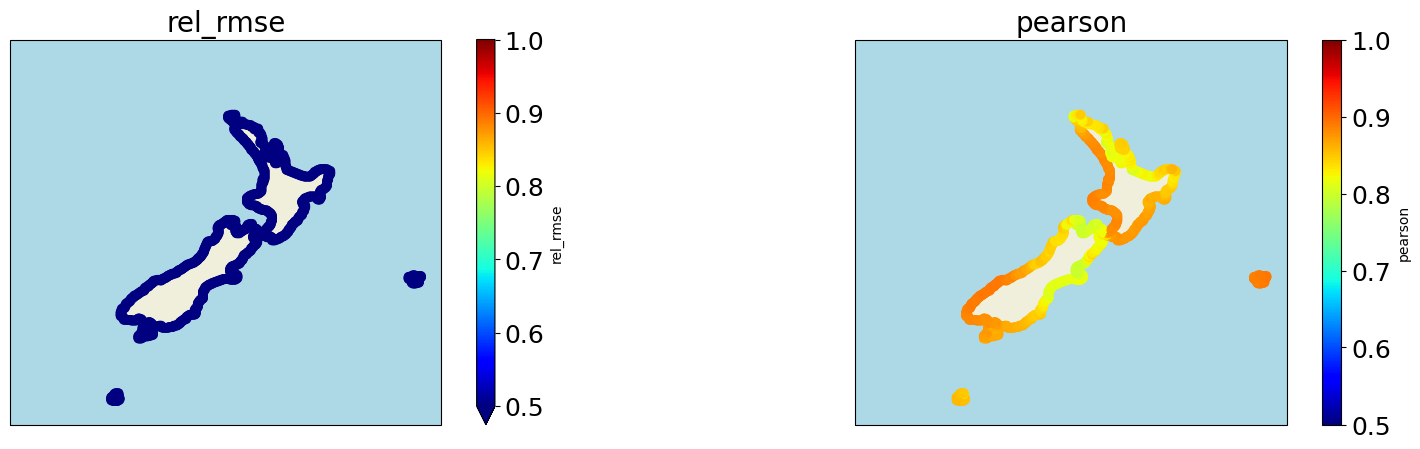

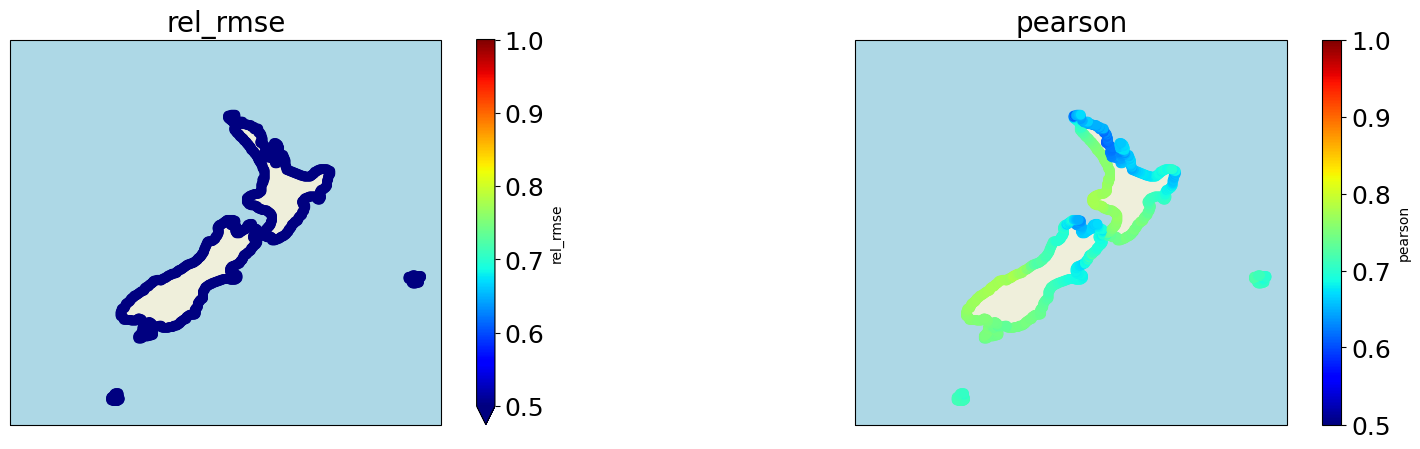

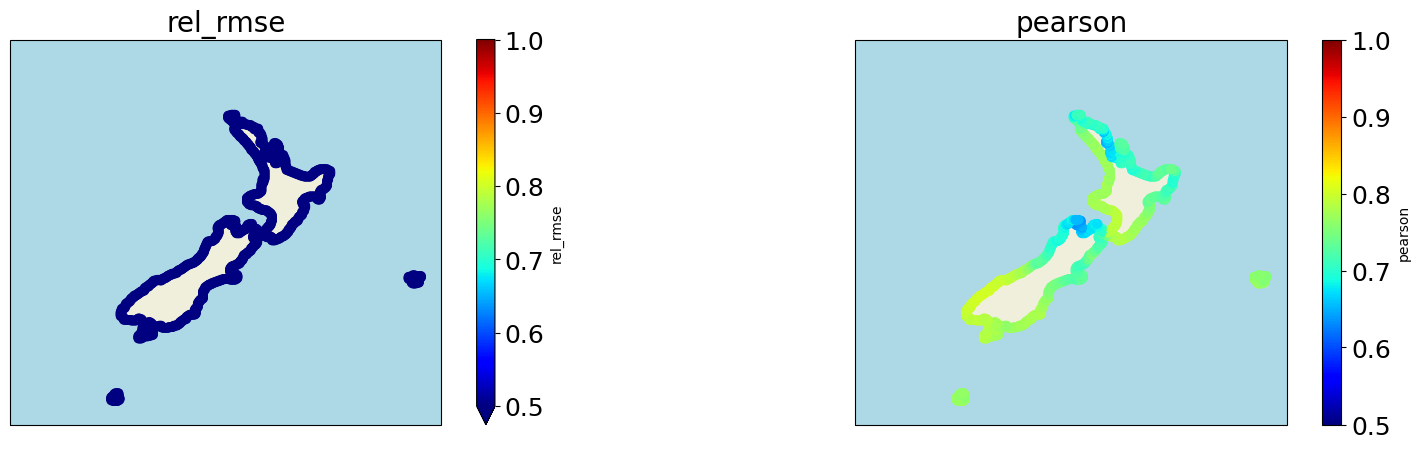

In [7]:
plot_stats(linear_all,plot_stats=['rel_rmse','pearson'],vmin=0.5,vmax=1)
plot_stats(knn_all_reg,plot_stats=['rel_rmse','pearson'],vmin=0.5,vmax=1)
plot_stats(xgboost_all_reg,plot_stats=['rel_rmse','pearson'],vmin=0.5,vmax=1)

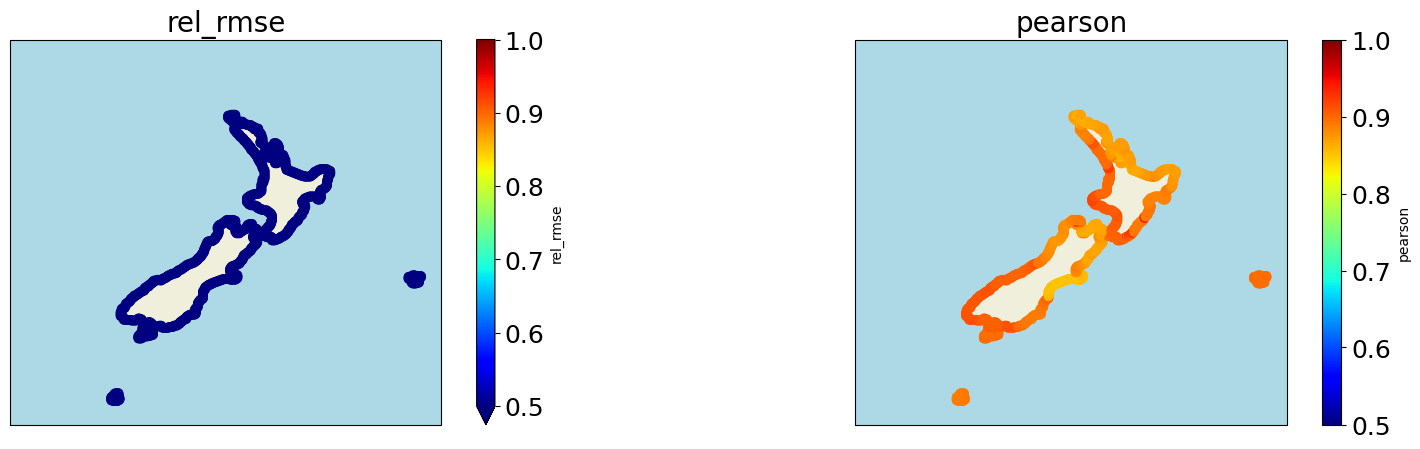

In [8]:
plot_stats(ordered_mdarbf.isel(experiment=23),plot_stats=['rel_rmse','pearson'],vmin=0.5,vmax=1)

In [9]:
# plot normalized final metrics
jeje = xr.open_dataset(
    '../data/statistics/experiments/experiment_mdarbf_shores_to_sites_all.nc'
)
jeje['pearson'] = (jeje['pearson']-jeje['pearson'].min())/(jeje['pearson'].max()-jeje['pearson'].min())
jeje['kgeprime'] = (jeje['kgeprime']-jeje['kgeprime'].min())/(jeje['kgeprime'].max()-jeje['kgeprime'].min())
jeje['ext_kgeprime_95'] = (jeje['ext_kgeprime_95']-jeje['ext_kgeprime_95'].min())/\
    (jeje['ext_kgeprime_95'].max()-jeje['ext_kgeprime_95'].min())
jeje['ext_kgeprime_99'] = (jeje['ext_kgeprime_99']-jeje['ext_kgeprime_99'].min())/\
    (jeje['ext_kgeprime_99'].max()-jeje['ext_kgeprime_99'].min())
jeje['ext_kgeprime_999'] = (jeje['ext_kgeprime_999']-jeje['ext_kgeprime_999'].min())/\
    (jeje['ext_kgeprime_999'].max()-jeje['ext_kgeprime_999'].min())

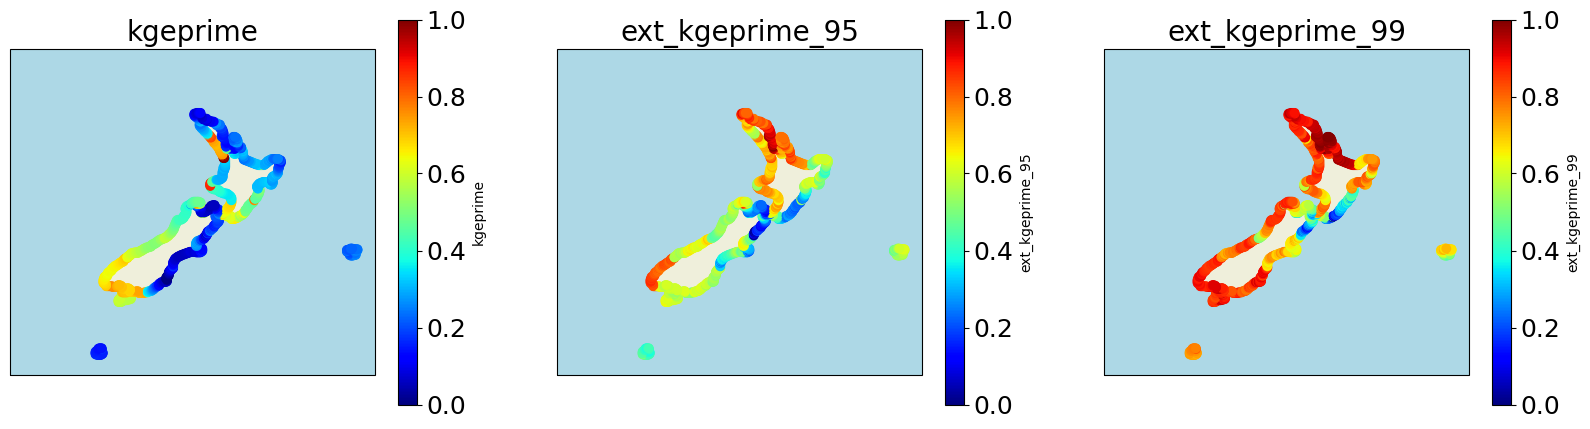

In [10]:
plot_stats(jeje,plot_stats=['kgeprime','ext_kgeprime_95','ext_kgeprime_99'],vmin=0,vmax=1)